In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### Columns of tx: 
- 1st column = ones, corresponding to the constant term of the regression
- 2nd column = data values $x_{n1}$ (heights)
### Rows of tx: 
- row i = 1, data value $x_{i1}$ (height)
### Why 1s in tx?
- For the constant term of the regression, to be able to do $w^T\cdot \tilde{X}$
### 3 peoples:
- $y \in R^3$
- $\tilde{X} \in R^{3x2}$
- $\tilde{X}_{32}$ corresponds to the height of the third person

# 1 Computing the Cost Function

### $L(w) = \frac{1}{2N}\sum_{i=1}^N (y_i - \tilde{X}_{i,(0:1)}w)^2 = \frac{1}{2N}\sum_{i=1}^N e_i^2 = \frac{1}{2N}\mathbf{e}^T\mathbf{e}$

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [4]:
def compute_loss(y, tx, w, fct='mse'):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y-tx.dot(w)
    if fct=='mse':
        return 1./(2.*y.shape[0])*e.dot(e)
    else:
        return 1./(2*y.shape[0])*np.sum(np.abs(e))

In [5]:
w = np.array([1,2])
print(compute_loss(y,tx,w))
print(compute_loss(y,tx,w,'mae'))

2694.48336589
36.1469610011


# 2 Grid Search

Fill in the function `grid_search()` below:

In [6]:
def grid_search(y, tx, w0, w1, fct='mse'):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i,ww0 in enumerate(w0):
        for j,ww1 in enumerate(w1):
            losses[i,j] = compute_loss(y,tx,[ww0,ww1],fct)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=15.55870336860953, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.272 seconds


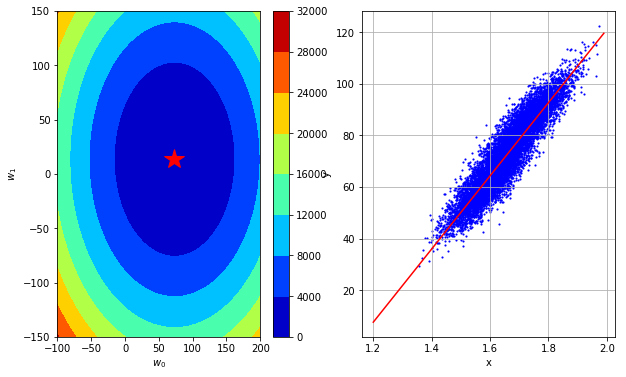

In [7]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

### b) No, it does not seem a good linear fit:
- because with `num_intervals=10`, the grid is too coarse and is not representative of the global set of values. Instead, when `num_intervals=50` or higher, it is more representative. 
- With `num_intervals=10`, the MSE plot is not smooth because the grid is too coarse to have a cost function that seems smooth.

### c) Fine vs coarse grid, computational cost:
- a finer grid gives more accurate results, 
- but a finer grid is more expensive computationaly.

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [8]:
def compute_gradient(y, tx, w, fct='mse'):
    """Compute the gradient."""
    e = y-tx.dot(w)
    if fct=='mse':
        return -1./y.shape[0]*tx.T.dot(e)
    else: #MAE
        return -1./y.shape[0]*tx.T.dot(np.sign(e)) # note: sign(0)=0

### a) Testing `compute_gradient`

In [9]:
yy = np.array([2,5])
ttxx = np.array([[1,3],[1,4]])
ww = np.array([1,2])
print(compute_gradient(yy,ttxx,ww))
print(compute_gradient(yy,ttxx,ww,'mae'))

[  4.5  15.5]
[ 1.   3.5]


This is conforming to what we find if we compute it by hand.
### b) Intuition about gradient values

In [10]:
w = np.array([100,20])
print(compute_gradient(y,tx,w))
w = np.array([50,10])
print(compute_gradient(y,tx,w))

[ 26.706078     6.52028757]
[-23.293922    -3.47971243]


The closer the values of w0,w1 are from the values that minimize $L(w)$, the smaller the gradient. The values move "less" when the values of w are close from the best ones since it remains just to refine the value, not to change them completely.
Because of the dependence on $x_{i1}$ in the second entry of the gradient, the larger is the value of the data (height), the more it will influence the slope (w1) --> quadrature dependence. This is why this method is not suited when there are some outliers.

Please fill in the functions `gradient_descent` below:

In [11]:
def gradient_descent(y, tx, initial_w, max_iters, gamma, fct='mse'):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y,tx,w,fct)
        gradLw = compute_gradient(y,tx,w,fct)
        w = w-gamma*gradLw
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [12]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.236712759167, w0=51.305745401473644, w1=9.435798704492269
Gradient Descent(1/49): loss=265.3024621089598, w0=66.69746902191571, w1=12.266538315840005
Gradient Descent(2/49): loss=37.87837955044127, w0=71.31498610804834, w1=13.115760199244333
Gradient Descent(3/49): loss=17.41021212017447, w0=72.70024123388814, w1=13.370526764265632
Gradient Descent(4/49): loss=15.568077051450459, w0=73.11581777164007, w1=13.446956733772023
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
Gradient Descent(6/49): loss=15.387363601208634, w0=73.27789262136334, w1=13.476764421879516
Gradient Descent(7/49): loss=15.386020684743531, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.38589982226167, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=15.385888944638307, w0=73.29348920882515, w1=13.47963283863509
Gradient Descent(10/49): loss=15.385887965652202, w0=73.29379216412117, w1=13

In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

### c) Reflexion on the results
- Yes, the cost is minimized up to a value of 15.39
- Yes, the algorithm has converged (values from the iteration 4 to 51 are the same ones). 
- It converges fast, in 4 iterations. 
- The final values found are very accurate. 

### d) Modifying the time step
- With 0.001 or 0.01, the convergence is so slow that it never happens whithin the maximum number of iterations. With 0.5, it converges reasonably fast; with 1 it converges in exactly 1 iteration. With 2, the behaviour oscillates between two states, while with 2.5, it diverges, i.e. the step size is too large. 
- With a fixed step size, the initialization of w is important. The further from the true value, the more steps we need for the convergence; the closer the better.

# 4 Stochastic gradient descent

In [14]:
def compute_stoch_gradient(y, tx, w, fct='mse'):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    e = y-np.dot(tx,w)
    if fct=='mse':
        return -1./y.shape[0]*tx.T.dot(e)
    else: #MAE
        return -1./y.shape[0]*tx.T.dot(np.sign(e)) # note: sign(0)=0

def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma, fct='mse'):
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = 0
        gradLw = 0
        for mini_y, mini_tx in batch_iter(batch_size=batch_size,tx=tx,y=y):
            loss += compute_loss(mini_y,mini_tx,w,fct)/batch_size
            gradLw += compute_stoch_gradient(mini_y,mini_tx,w,fct)/batch_size
        w = w-gamma*gradLw
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [15]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=3356.995395062516, w0=8.193894550288666, w1=5.506536878566651
Gradient Descent(1/49): loss=1284.7372425466476, w0=13.262892957364068, w1=-0.777975975034094
Gradient Descent(2/49): loss=2165.4782011887078, w0=19.843893187099223, w1=-2.9829168618413084
Gradient Descent(3/49): loss=1547.081182486157, w0=25.406412728613045, w1=-1.9188125113314667
Gradient Descent(4/49): loss=1564.7991197677418, w0=31.000693951018192, w1=-2.8087899475699394
Gradient Descent(5/49): loss=1175.5430383453233, w0=35.84949388160993, w1=-3.171253398167721
Gradient Descent(6/49): loss=1704.080427425226, w0=41.687439457624194, w1=1.9113951194725045
Gradient Descent(7/49): loss=533.9142546496656, w0=44.95520399825335, w1=-0.4264969681151958
Gradient Descent(8/49): loss=1780.3065654091074, w0=50.92229133699595, w1=8.969637580228785
Gradient Descent(9/49): loss=486.46741277377413, w0=54.04148165749187, w1=12.254269076100451
Gradient Descent(10/49): loss=163.02956752299247, w0=55.84719241795

In [16]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure_sgd(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure_sgd, n_iter=IntSlider(min=1, max=len(sgd_ws)))

A Jupyter Widget

<function __main__.plot_figure_sgd>

### Remark
A smaller step size is needed since we do not want the next values to completely change the fit, but we just want them to better it.

# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load and plot data containing outliers

In [17]:
height, weight, gender = load_data(sub_sample=True, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

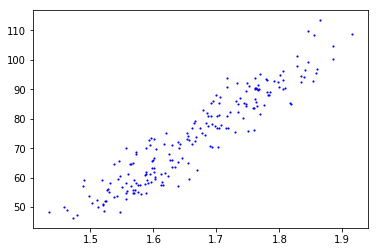

In [18]:
fig = plt.scatter(height,weight,marker=".",color='b',s=5)

In [19]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
red_gradient_losses, red_gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2829.272224438416, w0=7.3632272459731105, w1=1.4475704876437263
Gradient Descent(1/49): loss=2294.302754409306, w0=13.990131767348917, w1=2.750383926523079
Gradient Descent(2/49): loss=1860.9774836857268, w0=19.95434583658714, w1=3.922916021514496
Gradient Descent(3/49): loss=1509.9840143996273, w0=25.32213849890154, w1=4.978194907006768
Gradient Descent(4/49): loss=1225.6793042778872, w0=30.153151894984507, w1=5.927945903949812
Gradient Descent(5/49): loss=995.3924890792777, w0=34.50106395145917, w1=6.7827218011985515
Gradient Descent(6/49): loss=808.8601687684038, w0=38.41418480228637, w1=7.552020108722415
Gradient Descent(7/49): loss=657.7689893165962, w0=41.935993568030845, w1=8.244388585493892
Gradient Descent(8/49): loss=535.3851339606322, w0=45.105621457200876, w1=8.86752021458822
Gradient Descent(9/49): loss=436.25421112230123, w0=47.9582865574539, w1=9.428338680773114
Gradient Descent(10/49): loss=355.9581636232532, w0=50.52568514768163, w1=9.93307

In [20]:
def plot_figure_smallGrad(n_iter):
    fig = gradient_descent_visualization(
        red_gradient_losses, red_gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure_smallGrad, n_iter=IntSlider(min=1, max=len(red_gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure_smallGrad>

### Add two outliers

In [21]:
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

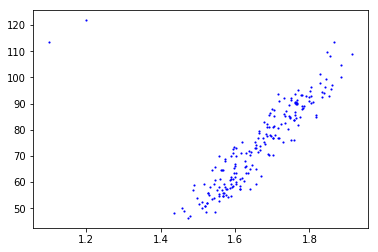

In [22]:
fig = plt.scatter(height,weight,marker=".",color='b',s=5)

In [23]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
out_red_gradient_losses, out_red_gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2869.8351145358524, w0=7.4067805854926325, w1=1.103489486598917
Gradient Descent(1/49): loss=2337.0932814935354, w0=14.072883112436008, w1=2.0966300245379443
Gradient Descent(2/49): loss=1905.5723967292581, w0=20.07237538668505, w1=2.9904565086830646
Gradient Descent(3/49): loss=1556.0404800701936, w0=25.47191843350918, w1=3.7949003444136746
Gradient Descent(4/49): loss=1272.9196275763513, w0=30.3315071756509, w1=4.5188997965712225
Gradient Descent(5/49): loss=1043.5917370563393, w0=34.705137043578446, w1=5.170499303513015
Gradient Descent(6/49): loss=857.8361457351294, w0=38.64140392471324, w1=5.756938859760628
Gradient Descent(7/49): loss=707.3741167649493, w0=42.18404411773455, w1=6.28473446038348
Gradient Descent(8/49): loss=585.4998732991036, w0=45.37242029145373, w1=6.759750500944047
Gradient Descent(9/49): loss=486.7817360917687, w0=48.241958847800994, w1=7.187264937448555
Gradient Descent(10/49): loss=406.82004495382716, w0=50.82454354851353, w1=7.5

In [24]:
def plot_figure_smallGrad_out(n_iter):
    fig = gradient_descent_visualization(
        out_red_gradient_losses, out_red_gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure_smallGrad_out, n_iter=IntSlider(min=1, max=len(out_red_gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure_smallGrad_out>

The final fit is a lot less accurate and the final value of the loss function is a lot higher. MSE cost function is very sensitive to outliers.

### Exercise 6

### a) and b)
Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)

In [25]:
gamma = 5

# Start gradient descent.
start_time = datetime.datetime.now()
mae_out_red_gradient_losses, mae_out_red_gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma, 'mae')
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=37.03390292746319, w0=5.0, w1=4.36394594827908e-15
Gradient Descent(1/49): loss=34.533902927463195, w0=10.0, w1=8.72789189655816e-15
Gradient Descent(2/49): loss=32.033902927463195, w0=15.0, w1=1.3091837844837241e-14
Gradient Descent(3/49): loss=29.533902927463192, w0=20.0, w1=1.745578379311632e-14
Gradient Descent(4/49): loss=27.033902927463192, w0=25.0, w1=2.1819729741395404e-14
Gradient Descent(5/49): loss=24.533902927463192, w0=30.0, w1=2.6183675689674486e-14
Gradient Descent(6/49): loss=22.03390292746319, w0=35.0, w1=3.054762163795357e-14
Gradient Descent(7/49): loss=19.53390292746319, w0=40.0, w1=3.491156758623265e-14
Gradient Descent(8/49): loss=17.033902927463192, w0=45.0, w1=3.927551353451173e-14
Gradient Descent(9/49): loss=14.533902927463188, w0=50.0, w1=4.3639459482790813e-14
Gradient Descent(10/49): loss=12.093040931680612, w0=54.7029702970297, w1=0.4434458674633023
Gradient Descent(11/49): loss=9.989804825322851, w0=58.81188118811881, w1=1.614

In [27]:
grid_losses_mae = grid_search(y, tx, grid_w0, grid_w1, 'mae')

def plot_figure_smallGrad_out_mae(n_iter):
    fig = gradient_descent_visualization(
        mae_out_red_gradient_losses, mae_out_red_gradient_ws, grid_losses_mae, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure_smallGrad_out_mae, n_iter=IntSlider(min=1, max=len(mae_out_red_gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure_smallGrad_out_mae>

### Comments on MAE wrt MSE
- The final fit with MAE is better than the one with MSE when there are outliers, that is MAE is less sensitive to MSE regarding the outliers. 
- TODO: **Find if the optimization ever encountered a non-differentiable point**

### c) SGD with MAE

In [28]:
gamma = 0.1

# Start SGD.
start_time = datetime.datetime.now()
mae_out_red_sgd_losses, mae_out_red_sgd_ws = stochastic_gradient_descent(y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2965.835989921395, w0=7.701734856409165, w1=3.9061821409635473
Gradient Descent(1/49): loss=2610.0696696389723, w0=14.926788032184376, w1=8.53701844526601
Gradient Descent(2/49): loss=1444.753078310242, w0=20.302200720174465, w1=13.18600670472484
Gradient Descent(3/49): loss=839.4630281595573, w0=24.39967073997829, w1=9.202099953369217
Gradient Descent(4/49): loss=1819.0086266125709, w0=30.4312685823623, w1=18.838096401592356
Gradient Descent(5/49): loss=810.2070679666094, w0=34.45670537348599, w1=24.660248593008937
Gradient Descent(6/49): loss=1011.2517168132221, w0=38.953930555335845, w1=26.22986192631043
Gradient Descent(7/49): loss=277.5557365620886, w0=41.31001092986507, w1=28.313759131168805
Gradient Descent(8/49): loss=849.2090808898557, w0=45.43119784843563, w1=23.39165569972679
Gradient Descent(9/49): loss=476.306387042198, w0=48.51764041891122, w1=22.831623141416625
Gradient Descent(10/49): loss=89.91997658267513, w0=49.85868461343036, w1=24.17445

In [29]:
def plot_figure_smallSdg_out_mae(n_iter):
    fig = gradient_descent_visualization(
        mae_out_red_sgd_losses, mae_out_red_sgd_ws, grid_losses_mae, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure_smallSdg_out_mae, n_iter=IntSlider(min=1, max=len(mae_out_red_sgd_ws)))

A Jupyter Widget

<function __main__.plot_figure_smallSdg_out_mae>

In the case of the stochastic gradient descent with MAE loss function, the approximation is as accurate as with th non stochastic gradient descent, even with the outliers. 
The step size has to be a lot smaller for the stochastic gradient descent than for the non-stochastic gradient descent. And it has to be a lot larger for the MAE than for the MSE in the case in which the gradient descent (not stochastic) is used. 